# 세그멘테이션을 통해 도로영역을 찾기
- U-Net과 U-Net++ 비교

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from keras import backend as K

### 데이터 증강

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

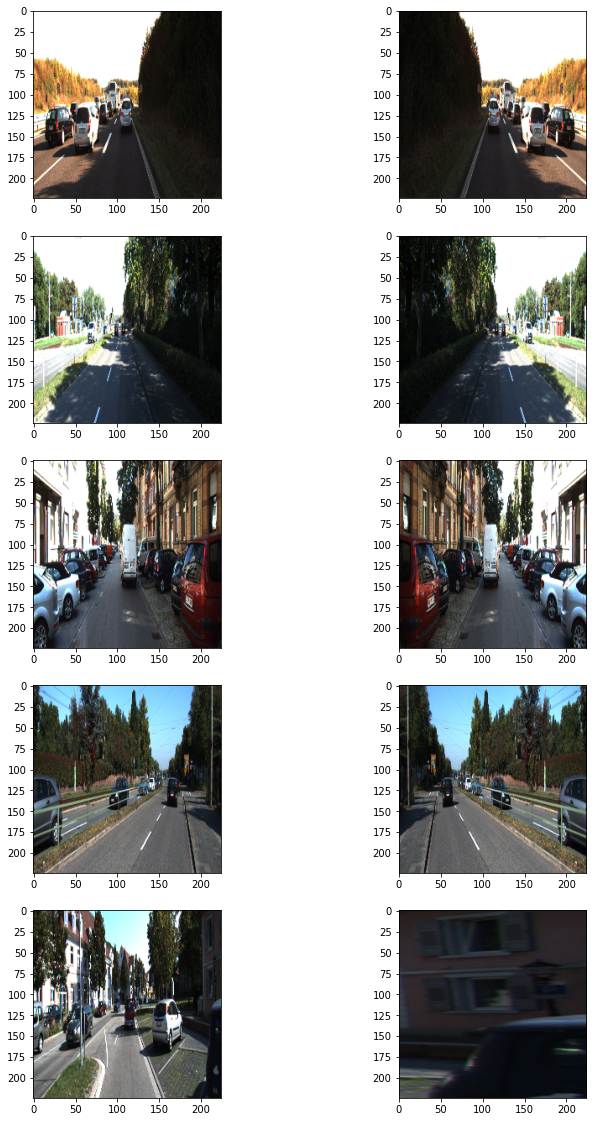

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### iou 계산함수

In [6]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()# intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum()# Union을 구하는 코드를 작성해주세요.
    iou_score = float(intersection / union)# iou 스코어를 구하되 결과값을 float로 만들어주세요!
    print('IoU : %f' % iou_score )
    return iou_score

In [7]:
def compute_iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection

    iou = tf.divide(intersection, union + tf.keras.backend.epsilon())
    return iou

In [8]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### U-Net 모델 설계

In [9]:
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def U_Net(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Encoding Path
    c1 = conv_block(inputs, 32)
    p1 = MaxPooling2D((2, 2), strides=(2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D((2, 2), strides=(2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = MaxPooling2D((2, 2), strides=(2, 2))(c3)

    c4 = conv_block(p3, 256)
    p4 = MaxPooling2D((2, 2), strides=(2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 512)

    # Decoding Path
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

### U-Net 학습
- 체크포인트 콜백을 통해 가장 val_loss가 낮은 모델을 저장

In [10]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_unet_model.h5',  # 저장 파일 경로
    monitor='val_loss',        # 검증 손실 기준
    save_best_only=True,       # 가장 낮은 값만 저장
    mode='min',                # 최소값 기준으로 비교
    verbose=1                  # 저장될 때 메시지 출력
)

In [11]:
model_path = 'seg_model_unet.h5'

model = U_Net()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    callbacks=[checkpoint_cb]
 )

model.save(model_path)

Epoch 1/100
11/11 [==============================] - 11s 254ms/step - loss: 0.6911 - val_loss: 0.6874

Epoch 00001: val_loss improved from inf to 0.68739, saving model to best_unet_model.h5
Epoch 2/100
11/11 [==============================] - 2s 219ms/step - loss: 0.6815 - val_loss: 0.6708

Epoch 00002: val_loss improved from 0.68739 to 0.67080, saving model to best_unet_model.h5
Epoch 3/100
11/11 [==============================] - 2s 218ms/step - loss: 0.6321 - val_loss: 0.4818

Epoch 00003: val_loss improved from 0.67080 to 0.48181, saving model to best_unet_model.h5
Epoch 4/100
11/11 [==============================] - 2s 218ms/step - loss: 0.2714 - val_loss: 0.2805

Epoch 00004: val_loss improved from 0.48181 to 0.28052, saving model to best_unet_model.h5
Epoch 5/100
11/11 [==============================] - 2s 214ms/step - loss: 0.2377 - val_loss: 0.2819

Epoch 00005: val_loss did not improve from 0.28052
Epoch 6/100
11/11 [==============================] - 2s 214ms/step - loss: 0.2

11/11 [==============================] - 2s 218ms/step - loss: 0.0171 - val_loss: 0.0188

Epoch 00049: val_loss did not improve from 0.01755
Epoch 50/100
11/11 [==============================] - 2s 218ms/step - loss: 0.0170 - val_loss: 0.0196

Epoch 00050: val_loss did not improve from 0.01755
Epoch 51/100
11/11 [==============================] - 2s 218ms/step - loss: 0.0149 - val_loss: 0.0192

Epoch 00051: val_loss did not improve from 0.01755
Epoch 52/100
11/11 [==============================] - 2s 222ms/step - loss: 0.0144 - val_loss: 0.0186

Epoch 00052: val_loss did not improve from 0.01755
Epoch 53/100
11/11 [==============================] - 2s 219ms/step - loss: 0.0149 - val_loss: 0.0191

Epoch 00053: val_loss did not improve from 0.01755
Epoch 54/100
11/11 [==============================] - 2s 220ms/step - loss: 0.0127 - val_loss: 0.0200

Epoch 00054: val_loss did not improve from 0.01755
Epoch 55/100
11/11 [==============================] - 2s 221ms/step - loss: 0.0137 - val_

11/11 [==============================] - 2s 217ms/step - loss: 0.0079 - val_loss: 0.0136

Epoch 00100: val_loss did not improve from 0.01267


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
del model

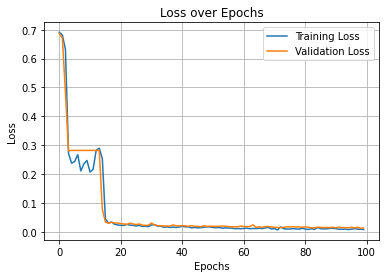

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model_path = 'best_unet_model.h5'
unet_model = tf.keras.models.load_model(model_path)

### U-Net 결과

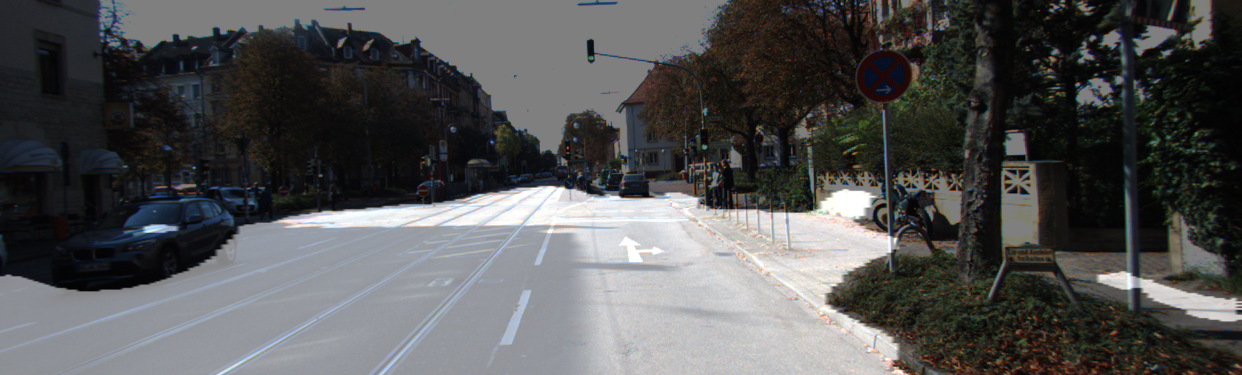

IoU : 0.846701


0.8467014712861889

In [16]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [17]:
del unet_model

### U-Net ++ 모델 설계

In [18]:
def U_NetPlusPlus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Encoding Path
    c11 = conv_block(inputs, 32)
    p1 = MaxPooling2D((2, 2))(c11)

    c21 = conv_block(p1, 64)
    p2 = MaxPooling2D((2, 2))(c21)
    
    u12 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c21)
    c12 = concatenate([u12, c11])
    c12 = conv_block(c12, 32)

    c31 = conv_block(p2, 128)
    p3 = MaxPooling2D((2, 2))(c31)
    
    u22 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c31)
    c22 = concatenate([u22, c21])
    c22 = conv_block(c22, 64)
    
    u13 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c22)
    c13 = concatenate([u13, c11, c12])
    c13 = conv_block(c13, 32)
    
    c41 = conv_block(p3, 256)
    p4 = MaxPooling2D((2, 2))(c41)
    
    u32 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c41)
    c32 = concatenate([u32, c31])
    c32 = conv_block(c32, 128)
    
    u23 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c32)
    c23 = concatenate([u23, c21, c22])
    c23 = conv_block(c23, 64)
    
    u14 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c23)
    c14 = concatenate([u14, c11, c12, c13])
    c14 = conv_block(c14, 32)
    
    c51 = conv_block(p4, 512)
    
    u42 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c51)
    c42 = concatenate([u42, c41])
    c42 = conv_block(c42, 256)
    
    u33 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c42)
    c33 = concatenate([u33, c31, c32])
    c33 = conv_block(c33, 128)
    
    u24 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c33)
    c24 = concatenate([u24, c21, c22, c23])
    c24 = conv_block(c24, 64)
    
    u15 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c24)
    c15 = concatenate([u15, c11, c12, c13, c14])
    c15 = conv_block(c15, 32)
    
    nestnet_output = Conv2D(1, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same')(c15)

    model = Model(inputs, nestnet_output)
    return model

### U-Net ++ loss
- BCE와 dice coef함께 사용

In [19]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [21]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_unetplusplus_model.h5',  # 저장 파일 경로
    monitor='val_loss',        # 검증 손실 기준
    save_best_only=True,       # 가장 낮은 값만 저장
    mode='min',                # 최소값 기준으로 비교
    verbose=1                  # 저장될 때 메시지 출력
)

### U-Net ++ 학습

In [22]:
model_path = 'seg_model_unetplusplus.h5'

model = U_NetPlusPlus()
model.compile(optimizer = Adam(1e-4), loss = [bce_dice_loss])
history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
    callbacks=[checkpoint_cb]
 )

model.save(model_path)

Epoch 1/100
11/11 [==============================] - 16s 635ms/step - loss: 0.3151 - val_loss: 0.3078

Epoch 00001: val_loss improved from inf to 0.30779, saving model to best_unetplusplus_model.h5
Epoch 2/100
11/11 [==============================] - 7s 595ms/step - loss: 0.3054 - val_loss: 0.2949

Epoch 00002: val_loss improved from 0.30779 to 0.29488, saving model to best_unetplusplus_model.h5
Epoch 3/100
11/11 [==============================] - 7s 601ms/step - loss: 0.2751 - val_loss: 0.2176

Epoch 00003: val_loss improved from 0.29488 to 0.21761, saving model to best_unetplusplus_model.h5
Epoch 4/100
11/11 [==============================] - 7s 598ms/step - loss: 0.0273 - val_loss: -0.3197

Epoch 00004: val_loss improved from 0.21761 to -0.31968, saving model to best_unetplusplus_model.h5
Epoch 5/100
11/11 [==============================] - 7s 595ms/step - loss: -0.3738 - val_loss: -0.3420

Epoch 00005: val_loss improved from -0.31968 to -0.34197, saving model to best_unetplusplus_m

11/11 [==============================] - 6s 577ms/step - loss: -0.7025 - val_loss: -0.6980

Epoch 00047: val_loss did not improve from -0.78876
Epoch 48/100
11/11 [==============================] - 6s 578ms/step - loss: -0.7377 - val_loss: -0.7552

Epoch 00048: val_loss did not improve from -0.78876
Epoch 49/100
11/11 [==============================] - 6s 578ms/step - loss: -0.7779 - val_loss: -0.7426

Epoch 00049: val_loss did not improve from -0.78876
Epoch 50/100
11/11 [==============================] - 6s 578ms/step - loss: -0.7222 - val_loss: -0.7592

Epoch 00050: val_loss did not improve from -0.78876
Epoch 51/100
11/11 [==============================] - 6s 577ms/step - loss: -0.5802 - val_loss: 0.1410

Epoch 00051: val_loss did not improve from -0.78876
Epoch 52/100
11/11 [==============================] - 6s 576ms/step - loss: -0.6343 - val_loss: -0.6751

Epoch 00052: val_loss did not improve from -0.78876
Epoch 53/100
11/11 [==============================] - 6s 576ms/step - lo

11/11 [==============================] - 6s 576ms/step - loss: -0.7705 - val_loss: -0.7776

Epoch 00099: val_loss did not improve from -0.79505
Epoch 100/100
11/11 [==============================] - 6s 576ms/step - loss: -0.8013 - val_loss: -0.7800

Epoch 00100: val_loss did not improve from -0.79505


In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [24]:
del model

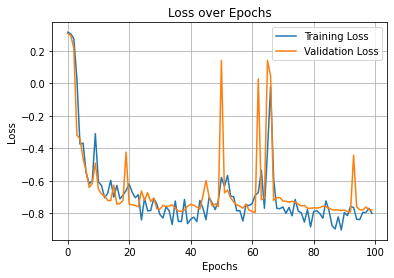

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### U-Net ++ 결과

In [26]:
model_path = 'best_unetplusplus_model.h5'
unetplusplus_model = tf.keras.models.load_model(model_path, custom_objects={"bce_dice_loss": bce_dice_loss})

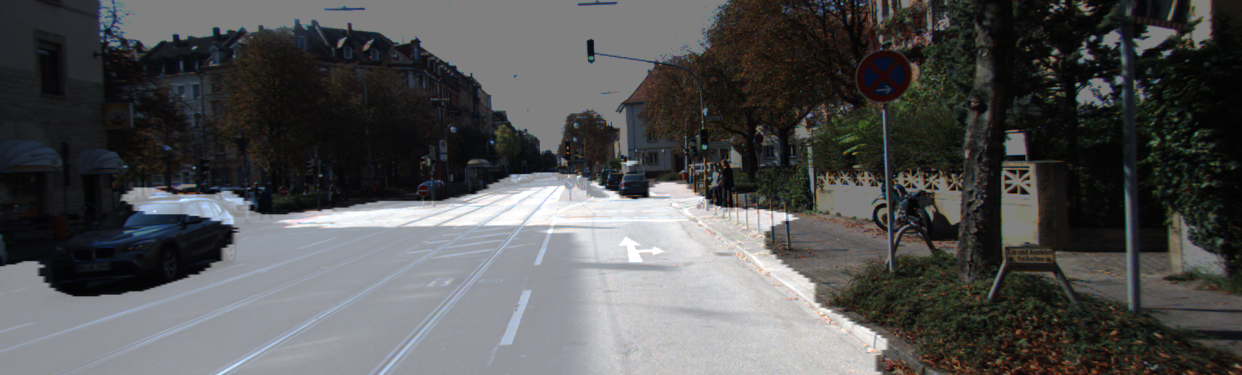

IoU : 0.883333


0.8833333333333333

In [27]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unetplusplus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### 회고
- 같은 코드 같은 환경에서 실행하는데 u-net모델의 경우 학습이 진행되지 않았습니다. val_loss가 0.2819에서 멈추고 결과도 재대로 나오지 않았습니다. 하지만 분명히 같은 코드 같은 환경인데 될때가 간간이 있었습니다. 정상작동할때의 사진을 찍지 못했으나 약 0.85 정도의 iou를 나타내었습니다. 오랜시간 다른 시도를 했지만 원인은 찾지 못했습니다.
- u-net과 u-net++에서 iou기준 약 0.04~0.05의 성능이 향상되었습니다.
### 추가실험1
- deep supervision
    - 논문 및 깃헙의 내용에 u-net++의 deep supervision내용을 토대로 진행했습니다.

In [28]:
def U_NetPlusPlus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Encoding Path
    c11 = conv_block(inputs, 32)
    p1 = MaxPooling2D((2, 2))(c11)

    c21 = conv_block(p1, 64)
    p2 = MaxPooling2D((2, 2))(c21)
    
    u12 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c21)
    c12 = concatenate([u12, c11])
    c12 = conv_block(c12, 32)

    c31 = conv_block(p2, 128)
    p3 = MaxPooling2D((2, 2))(c31)
    
    u22 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c31)
    c22 = concatenate([u22, c21])
    c22 = conv_block(c22, 64)
    
    u13 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c22)
    c13 = concatenate([u13, c11, c12])
    c13 = conv_block(c13, 32)
    
    c41 = conv_block(p3, 256)
    p4 = MaxPooling2D((2, 2))(c41)
    
    u32 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c41)
    c32 = concatenate([u32, c31])
    c32 = conv_block(c32, 128)
    
    u23 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c32)
    c23 = concatenate([u23, c21, c22])
    c23 = conv_block(c23, 64)
    
    u14 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c23)
    c14 = concatenate([u14, c11, c12, c13])
    c14 = conv_block(c14, 32)
    
    c51 = conv_block(p4, 512)
    
    u42 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c51)
    c42 = concatenate([u42, c41])
    c42 = conv_block(c42, 256)
    
    u33 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c42)
    c33 = concatenate([u33, c31, c32])
    c33 = conv_block(c33, 128)
    
    u24 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c33)
    c24 = concatenate([u24, c21, c22, c23])
    c24 = conv_block(c24, 64)
    
    u15 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c24)
    c15 = concatenate([u15, c11, c12, c13, c14])
    c15 = conv_block(c15, 32)
    
    nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same')(c12)
    nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same')(c13)
    nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same')(c14)
    nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same')(c15)

    model = Model(inputs, outputs=[nestnet_output_1, nestnet_output_2, nestnet_output_3, nestnet_output_4])
    return model

In [ ]:
def deep_supervision_loss(y_true, y_pred):
    losses = [bce_dice_loss(y_true, output) for output in y_pred]
    return tf.reduce_mean(losses)